# Introduction to Dask
There are many occasions when we have to work with datasets that are so big we can't just load all of it into memory. If we have to work with such a data, what is the solution? One of the libraries in python for this type of problems is __Dask__. Dask is a library for parallel computing. It helps us perform common pandas and numpy opperations on large datasets. In this tutorial we will learn about some of the features of Dask and how it can help us.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import os
import logging
import psutil

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For the beginning to see the difference in the performance of Dask vs Pandas, let's read a 70 MB csv file with both libraries. Of course 70 MB is not considered a large file and we can easily fit it into memory, but it is large enough to see the advantage of using Dask.

In [2]:
path = "../../data/processed/MNIST/train.csv"

We are also defining a function to report memory usage, so we can see how each method affect the memory.

In [3]:
def memory_usage():
    """String with current memory usage in MB. Requires `psutil` package."""
    pid = os.getpid()
    mem_bytes = psutil.Process(pid).memory_info().rss
    print('[Process {} uses {:.1f}MB]'.format(pid, mem_bytes / 1024 / 1024))
    return mem_bytes / 1024 / 1024

In [4]:
memory_usage()

[Process 3303031 uses 116.1MB]


116.05078125

You should be able to see the amount of used memory.<br>
Now let's load the data with pandas and see how long it takes to load and how much memory it takes.

In [5]:
%%time
df1 = pd.read_csv(path)

CPU times: user 3.41 s, sys: 315 ms, total: 3.73 s
Wall time: 3.74 s


In [6]:
memory_usage()

[Process 3303031 uses 624.0MB]


624.02734375

The memory usage has gone up by about ~250 MB.<br>
Now do the same with Dask.

In [7]:
%%time
df2=dd.read_csv(path)

CPU times: user 271 ms, sys: 235 µs, total: 271 ms
Wall time: 270 ms


In [8]:
memory_usage()

[Process 3303031 uses 624.0MB]


624.02734375

Dask read the file in a fraction of a second and used only about 3 MB of memory. How is that possible?

It's because Dask doesn't load the data into memory. The data is still on the disk. It only reads the data when it needs to perform calculations.


Now, let's calculate the mean for the first 100 columns.

In [9]:
%%time
df1.iloc[:,:100].mean()

CPU times: user 4.35 ms, sys: 3.89 ms, total: 8.24 ms
Wall time: 7.08 ms


label       4.456643
pixel0      0.000000
pixel1      0.000000
pixel2      0.000000
pixel3      0.000000
             ...    
pixel94     3.768381
pixel95     5.713881
pixel96     7.751238
pixel97    10.048857
pixel98    12.067738
Length: 100, dtype: float64

As you can see pandas does the calculations in a fraction of a second. <br>
Let's try Dask:

In [10]:
%%time
avg = df2.iloc[:,100:200].mean()

CPU times: user 76.8 ms, sys: 199 µs, total: 77 ms
Wall time: 75.2 ms


Dask is also did the operation very quickly. Let's have a look at the output.

In [11]:
avg

Dask Series Structure:
npartitions=1
pixel100    float64
pixel99         ...
dtype: float64
Dask Name: dataframe-mean, 15 tasks

It's not returning any numbers. What is happening?<br>
The reason is Dask has not calculated the result yet. It only creates a dependency graph (also called Directed Acyclec Graph - DAG), which is basically how the calculations will take place. We need to execute the graph to see the result.

In [12]:
%%time
avg.compute()

CPU times: user 4.52 s, sys: 543 ms, total: 5.06 s
Wall time: 4.21 s


pixel99     13.404952
pixel100    13.072714
pixel101    11.573810
pixel102     9.295500
pixel103     6.708333
              ...    
pixel194     0.345714
pixel195     0.025024
pixel196     0.000000
pixel197     0.017810
pixel198     0.112476
Length: 100, dtype: float64

Now we can see the results. Also, we can see that this step is the most time consuming step of all. It's because this is where Dask actually goes to disk and reads the data. If you add up the time for all the steps (reading the file and performing calculations) you will see that both take almost the same amount of time to do the operation, with pandas being slightly faster. This shows that Dask is not doing any magic. It's doing the same steps but it's doing it without using as much memory. However, Dask can perform operations in parallel using multiple cpu cores and even multiple machines. 

We mentioned that Dask creates a dependency graph before doing the calculations. We can have a look at this graph and see how it is taking place:

<div class='alert alert-danger'>To see the graph you need a library called <b>GraphViz</b>. If this library is not installed on your system you will not be able to see the graph.</div>

Here is one we prepared earlier:

![](img/dask_graphviz.png)

In [13]:
# Try commenting this out
# # avg.visualize()

You can also create a progress bar for each computation:

In [14]:
from dask.diagnostics import ProgressBar
avg = df2.iloc[:, 100:200].mean()
task = avg.mean()

In [15]:
with ProgressBar():
    task.compute()

[########################################] | 100% Completed |  4.6s


[Dask dataframe](https://docs.dask.org/en/latest/dataframe-api.html) is very similar to pandas dataframe. It's mostly a subset of the pandas api. Even though the functionalities are limited but you will find many methods from pandas dataframe in Dask as well.

A few operations are missing, and some are especially expensive: those that read the whole array. An example is sort.

In [16]:
task = df2.rolling(window=10).mean().max()

In [17]:
with ProgressBar():
    ma_max = task.compute()

[########################################] | 100% Completed |  5.1s


In [18]:
ma_max

label       7.8
pixel0      0.0
pixel1      0.0
pixel2      0.0
pixel3      0.0
           ... 
pixel779    6.2
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
Length: 785, dtype: float64

In [19]:
task = df2[["label", "pixel100", "pixel300", "pixel500"]].groupby("label").mean()

In [20]:
with ProgressBar():
    result = task.compute()

[########################################] | 100% Completed |  4.3s


In [21]:
result

,pixel100,pixel300,pixel500
label,,,
0,5.214182,159.355034,12.281704
1,1.353117,3.631298,0.230145
2,36.265262,80.125209,20.892267
3,5.035164,44.818433,0.851299
4,0.815570,86.038802,1.606582
5,3.061660,26.764954,2.630303
6,79.729272,21.919749,10.156877
7,0.000000,107.960918,0.960464
8,0.739109,111.389614,1.482402


 <div class="alert alert-success">
  <h2>Exercise</h2>

Use Dask dataframe of MNIST (df2) and follow these steps:
    
1. Add a new column called `sum` to the dataframe which contains sum of all the pixels
2. Use groupby to find the mean value for `sum` for each label
      

  <details>
  <summary><b>→ Hints</b></summary>

  * Columns 1 onwards are the pixels. You can access them with `pixels=df2.iloc[:, 1:]`
  * Instead of `df['sum']=pixels.sum()` try `df['sum']=pixels.sum(axis=1)` because we want to sum along columns, not rows
  * If the dask output is confusing, try with df1 first
  * to groupby use `df2.groupby('label').?`, where you replace the `?` with the aggregation operation

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
    # With pandas
    pixels = df1.loc[:, ['pixel' in c for c in df1.columns]]
    df1['sum']=pixels.sum(axis=1)
    task = df1[['label','sum']].groupby('label').mean()
    print(result)

    # With dask
    pixels = df2.loc[:, ['pixel' in c for c in df2.columns]]
    df2['sum']=pixels.sum(axis=1)
    task = df2[['label','sum']].groupby('label').mean()
    with ProgressBar():
        result=task.compute() 
    print(result)
  ```

  </details>

  </div>

## When to use Dask DataFrame?

Lets visit [the dask page](https://docs.dask.org/en/latest/dataframe.html#common-uses-and-anti-uses) to look at when we should use it

It is harder so only if you dataset is larger than memory.

If fact also consider:
- a database (if you have lots of structured queries)
- https://downloadmoreram.com/ ;p
- dask array

## Dask Array
Dask is not just used to replace pandas. There are also multiple numpy functions which can be replaced by Dask. Dask array is Dask equivalent of a numpy array. By doing so, we can perform the computations in parallel and get the results faster.

In [22]:
from dask import array

In [23]:
big_array = array.random.normal(size=(10000000, 100), chunks=200000)

In [24]:
big_array

dask.array<normal, shape=(10000000, 100), dtype=float64, chunksize=(200000, 100), chunktype=numpy.ndarray>

This data takes 8 GB if we wanted to store it in RAM. But Dask only generates the numbers in chunks when it needs them. So at each steps it has to deal with a chunk which is ~160 MB in this case.

In [25]:
task = (big_array * big_array).mean(axis=1)
with ProgressBar():
    res = task.compute()

[########################################] | 100% Completed |  7.8s


We can set the chunk size:

In [26]:
big_array = array.random.normal(size=(10000000, 100), chunks=(2 ** 19, 100))
big_array

dask.array<normal, shape=(10000000, 100), dtype=float64, chunksize=(524288, 100), chunktype=numpy.ndarray>

In [27]:
task = (big_array * big_array).mean(axis=1)
with ProgressBar():
    res = task.compute()

[########################################] | 100% Completed |  9.4s


We can also apply most of common numpy functions to the array.

In [28]:
task = np.sin(big_array).mean(axis=0)
with ProgressBar():
    res = task.compute()

[########################################] | 100% Completed | 12.3s


In [29]:
task

dask.array<mean_agg-aggregate, shape=(100,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>

In [30]:
res

array([-1.17109224e-04, -2.37748610e-05,  1.67655302e-04,  9.72602555e-05,
       -1.21246755e-04,  1.86229870e-04, -2.90821428e-04, -2.79825330e-04,
        1.36715765e-04, -5.00321866e-06, -8.71579028e-05, -5.53870480e-05,
       -2.99278608e-04,  8.90632815e-05,  2.23756405e-05, -8.12409603e-05,
        1.15169616e-04, -3.89092182e-04, -1.53707025e-06,  2.39661084e-04,
       -1.80096422e-04,  2.74128387e-04, -2.44078965e-04, -1.83305381e-04,
       -3.63807417e-05, -3.47435128e-04, -7.35919945e-05,  2.29875992e-04,
        2.71309995e-04,  2.23522462e-04, -3.06297908e-04,  1.31446736e-04,
        4.68200987e-04, -4.46962346e-04, -1.98344059e-04, -2.83531171e-04,
        1.67231803e-04,  2.33479578e-04, -1.16014913e-04, -8.46083969e-05,
        3.82956303e-05, -7.75966025e-05, -9.45842315e-05, -1.46859581e-04,
        2.66761928e-05,  5.43888756e-04,  1.30971229e-04,  3.03536632e-04,
       -2.70213468e-04, -3.35363834e-04, -4.89288567e-04, -1.24321567e-04,
        9.31827182e-06,  

### Exercise

- Create two Dask random arrays of size 10,000,000-by-100. 
- Find the difference between the two `y = ..`
- and pass it to `array.linalg.norm` using argument `axis=1`. 
- Calculate the result and create a histogram of it.

In [31]:
from matplotlib.pyplot import hist

 <div class="alert alert-success">
  <h2>Exercise</h2>

  Description:

- Create two Dask random arrays of size 10,000,000-by-100. 
- Find the difference between the two `y = ..`
- and pass it to `array.linalg.norm` using argument `axis=1`. 
- Calculate the result and create a histogram of it.
      

  <details>
  <summary><b>→ Hints</b></summary>
      
      Replace the question marks `?`

```python
a = array.random.normal(size=(10000000, 100), chunks=200000)
b = array.random.normal(size=(10000000, 100), chunks=200000)
r = array.linalg.norm(?, axis=1)
r.?
```

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
    x1 = array.random.random(size=(10000000,100))
    x2 = array.random.random(size=(10000000,100))
    y = x2-x1
    d = array.linalg.norm(y,axis=1)
    with ProgressBar():
        result = d.compute()
    hist(result,bins=100);
  ```

  </details>

  </div>

## Delayed
Dask delayed is a method for parallelising code where you can't write your code directly as dataframe or array operation. `Dask.delayed` is an easy-to-use tool to quickly parallelise these tasks.

Consider the following functions. The first one takes an input, waits for one second and returns the value. The second function takes two inputs, waits for one second and returns the sum. We are using these functions to represent tasks that are time consuming.

In [32]:
from time import sleep


def task1(x):
    sleep(1)
    return x


def task2(x, y):
    sleep(1)
    return x + y

Now, if we pass two values separately into the first function and then pass the results into the second function, we will have the following code:

In [33]:
%%time
x1 = task1(1)
x2 = task1(2)
y = task2(x1,x2)

CPU times: user 4.81 ms, sys: 74 µs, total: 4.89 ms
Wall time: 3 s


Since each of these functions are taking one second; therefore, the entire block takes three seconds. But the calculation for `x1` is totally independent of the calculation for `x2`. If we were able to do these operation simultaneously we could save time. This is where `Dask.delayed` comes into play. We need to convert the functions into `delayed` functions so Dask can handle parallelisation.

In [34]:
task1_delayed = dask.delayed(task1)
task2_delayed = dask.delayed(task2)

And now instead of the original function we use the delayed functions:

In [35]:
%%time
x1 = task1_delayed(1)
x2 = task1_delayed(2)
y = task2_delayed(x1,x2)

CPU times: user 524 µs, sys: 0 ns, total: 524 µs
Wall time: 465 µs


In [36]:
%%time
y.compute()

CPU times: user 5.72 ms, sys: 0 ns, total: 5.72 ms
Wall time: 2 s


3

And we saved one second! `x1` and `x2` where calculated in parallel, and then `y` was calculated using `x1` and `x2`.

We can directly create delayed functions using `dask.delayed` decorator.

In [37]:
@dask.delayed
def task1(x):
    sleep(1)
    return x


@dask.delayed
def task2(x, y):
    sleep(1)
    return x + y

In [38]:
%%time
x1 = task1(1)
x2 = task1(2)
y = task2(x1,x2)
y.compute()

CPU times: user 1.85 ms, sys: 3.8 ms, total: 5.65 ms
Wall time: 2 s


3

# Introduction to Numba

## What is Numba?

Numba is a **just-in-time**, **type-specializing**, **function compiler** for accelerating **numerically-focused** Python.  That's a long list, so let's break down those terms:

 * **function compiler**: Numba compiles Python functions, not entire applications, and not parts of functions.  Numba does not replace your Python interpreter, but is just another Python module that can turn a function into a (usually) faster function. 
 * **type-specializing**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using.  Python functions are designed to operate on generic data types, which makes them very flexible, but also very slow.  In practice, you only will call a function with a small number of argument types, so Numba will generate a fast implementation for each set of types.
 * **just-in-time**: Numba translates functions when they are first called.  This ensures the compiler knows what argument types you will be using.  This also allows Numba to be used interactively in a Jupyter notebook just as easily as a traditional application
 * **numerically-focused**: Currently, Numba is focused on numerical data types, like `int`, `float`, and `complex`.  There is very limited string processing support, and many string use cases are not going to work well on the GPU.  To get best results with Numba, you will likely be using NumPy arrays.


### First Steps

Let's write our first Numba function and compile it for the **CPU**.  The Numba compiler is typically enabled by applying a *decorator* to a Python function.  Decorators are functions that transform Python functions.  Here we will use the CPU compilation decorator:

In [39]:
from numba import jit
import math


@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x)
    y = abs(y)
    t = min(x, y)
    x = max(x, y)
    t = t / x
    return x * math.sqrt(1 + t * t)

The above code is equivalent to writing:
``` python
def hypot(x, y):
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)
    
hypot = jit(hypot)
```
This means that the Numba compiler is just a function you can call whenever you want!

Let's try out our hypotenuse calculation:

In [40]:
hypot(3.0, 4.0)

5.0

The first time we call `hypot`, the compiler is triggered and compiles a machine code implementation for float inputs.  Numba also saves the original Python implementation of the function in the `.py_func` attribute, so we can call the original Python code to make sure we get the same answer:

In [41]:
hypot.py_func(3.0, 4.0)

5.0

### Benchmarking

An important part of using Numba is measuring the performance of your new code.  Let's see if we actually sped anything up.  The easiest way to do this in the Jupyter notebook is to use the `%timeit` magic function.  Let's first measure the speed of the original Python:

In [42]:
%timeit hypot.py_func(3.0, 4.0)

1.18 µs ± 33.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


The `%timeit` magic runs the statement many times to get an accurate estimate of the run time.

In [43]:
%timeit hypot(3.0, 4.0)

322 ns ± 8.11 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba did a pretty good job with this function.  It's 3x faster than the pure Python version.

Of course, the `hypot` function is already present in the Python module:

In [44]:
%timeit math.hypot(3.0, 4.0)

247 ns ± 1.24 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Python's built-in is even faster than Numba!  This is because Numba does introduce some overhead to each function call that is larger than the function call overhead of Python itself.  Extremely fast functions (like the above one) will be hurt by this.

(However, if you call one Numba function from another one, there is very little function overhead, sometimes even zero if the compiler inlines the function into the other one.)

### How does Numba work?

The first time we called our Numba-wrapped `hypot` function, the following process was initiated:

![Numba Flowchart](img/numba_flowchart.png "The compilation process")

We can see the result of type inference by using the `.inspect_types()` method, which prints an annotated version of the source code:

In [45]:
hypot.inspect_types()

hypot (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-39-6918c9bc301b>
# --- LINE 5 --- 
# label 0

@jit

# --- LINE 6 --- 

def hypot(x, y):

    # --- LINE 7 --- 

    # Implementation from https://en.wikipedia.org/wiki/Hypot

    # --- LINE 8 --- 
    #   x = arg(0, name=x)  :: float64
    #   y = arg(1, name=y)  :: float64
    #   $0.1 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.3 = call $0.1(x, func=$0.1, args=[Var(x, <ipython-input-39-6918c9bc301b> (8))], kws=(), vararg=None)  :: (float64,) -> float64
    #   del x
    #   del $0.1
    #   x.1 = $0.3  :: float64
    #   del $0.3

    x = abs(x)

    # --- LINE 9 --- 
    #   $0.4 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.6 = call $0.4(y, func=$0.4, args=[Var(y, <ipython-input-39-6918c9bc301b> (8))], kws=(), vararg=None)  :: (float64,) -> float64
    #   del y
    #   

Note that Numba's type names tend to mirror the NumPy type names, so a Python `float` is a `float64` (also called "double precision" in other languages).  Taking a look at the data types can sometimes be important in GPU code because the performance of `float32` and `float64` computations will be very different on CUDA devices.  An accidental upcast can dramatically slow down a function.

### When Things Go Wrong

Numba cannot compile all Python code.  Some functions don't have a Numba-translation, and some kinds of Python types can't be efficiently compiled at all (yet).  For example, Numba does not support `FrozenSet` (as of this tutorial):

In [46]:
@jit
def cannot_compile(x):
    return "a" in x


cannot_compile(frozenset(("a", "b", "c")))

<ipython-input-46-93f85c190644>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cannot_compile" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-46-93f85c190644> (3)

File "<ipython-input-46-93f85c190644>", line 3:
def cannot_compile(x):
    return "a" in x
    ^

  @jit
/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "cannot_compile" was compiled in object mode without forceobj=True.

File "<ipython-input-46-93f85c190644>", line 2:
@jit
def cannot_compile(x):
^

  state.func_ir.loc))
/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/lat

True

Wait, what happened??  By default, Numba will fall back to a mode, called "object mode," which does not do type-specialization.  Object mode exists to enable other Numba functionality, but in many cases, you want Numba to tell you if type inference fails.  You can force "nopython mode" (the other compilation mode) by passing arguments to the decorator:

In [47]:
@jit(nopython=True)
def cannot_compile(x):
    return "a" in x

try:
    cannot_compile(frozenset(("a", "b", "c")))
except Exception as e:
    logging.exception(e)

ERROR:root:Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
[1] During: typing of argument at <ipython-input-47-13ba80368805> (3)

File "<ipython-input-47-13ba80368805>", line 3:
def cannot_compile(x):
    return "a" in x
    ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'frozenset'>

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and tra

Now we get an exception when Numba tries to compile the function, with an error that says:
```
- argument 0: cannot determine Numba type of <class 'frozenset'>
```
which is the underlying problem. Numba doesn't know about frozenset. There are classes that we use regularly in our code but they might not be defined in Numba. An example of a common class that you cannot use in Numba is pandas data frames. <br>Now the question is: what does Numba support? Some of the types/classes that are supported by Numba are listed below:
* Numbers (integers, floats, etc)
* Numpy arrays
* Strings
* Lists and tuples (note that a list/tuple of numbers or strings is supported but a list of lists is not)

So, if we want the last example to be compiled successfully by Numba jit, we need to use a tuple or a list.

In [48]:
@jit(nopython=True)
def can_compile(x):
    return "a" in x


can_compile(("a", "b", "c"))

True

### Exercise
Gregory–Leibniz infinite series converges to $\pi$:
$$\pi = \frac{4}{1} - \frac{4}{3} + \frac{4}{5} - \frac{4}{7} + \frac{4}{9} - \frac{4}{11} + \frac{4}{13} - \cdots$$

Write a Numba function which calculates the sum of first $n$ terms in this series. Then test its speed agains normal Python function for $ n = 1000000$.

In [49]:
# Code Here

<details><summary>Solution</summary>

```Python
    @jit
    def gl_pi(n):
        pi = 0
        for i in range(n):
            if i%2 ==0:
                pi += 4/(2*i+1)
            else:
                pi -= 4/(2*i+1)
        return pi 
```

<b>Numba function speed test:</b>
```Python
    %timeit gl_pi(1000000) 
```
    
<b>Normal Python function speed test:</b>
```Python
    %timeit gl_pi.py_func(1000000) 
```
    
</details>

# Xarray

Xarray is pandas for N-dimensional data. It also has a [dask backend](http://xarray.pydata.org/en/stable/dask.html)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.tutorial.open_dataset('rasm').load().chunk(dict(time=10))
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
    yc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 dask.array<chunksize=(10, 205, 275), meta=np.ndarray>
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

<xarray.Dataset>
Dimensions:  (x: 275, y: 205)
Coordinates:
    time     object 1981-07-17 00:00:00
    xc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
    yc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    Tair     (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

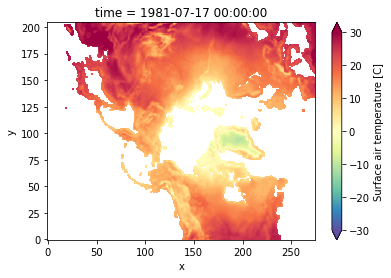

In [2]:
# You can use isel instead of iloc. You always need to specify the dimension
ds.isel(time=10)['Tair'].plot.pcolormesh(
        vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

ds.isel(time=10)

In [3]:
# You can also resample by date
res = ds.resample(time='A').mean().isel(x=200, y=200)['Tair']
# The result is a dask array
res

<xarray.DataArray 'Tair' (time: 4)>
dask.array<getitem, shape=(4,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-12-31 00:00:00 ... 1983-12-31 00:00:00
    xc       float64 dask.array<chunksize=(), meta=np.ndarray>
    yc       float64 dask.array<chunksize=(), meta=np.ndarray>

In [4]:
# But you can use .compute
res.compute()

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'Tair' (time: 4)>
array([ 6.75662201,  8.97479849, 10.49235584,  9.59892096])
Coordinates:
  * time     (time) object 1980-12-31 00:00:00 ... 1983-12-31 00:00:00
    xc       float64 42.47
    yc       float64 44.82

<div class="alert alert-success">
  <h2>Exercise</h2>

  1. Look at the output of `ds.time.dt.season`
  2. Try grouping by season and getting the mean
  3. Plot each season (use the plotting code from above)
      

  <details>
  <summary><b>→ Hints</b></summary>

  * You do a for loop over groups `for season, ds_season in ds.groupby(ds.time.dt.season):`
  * You need to remove the time dimension, with `.mean('time')`
  * Use  `mean['Tair'].plot.pcolormesh()` to plot

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
    for season, ds_season in ds.groupby(ds.time.dt.season):    
        mean = ds_season.mean('time')
        mean['Tair'].plot.pcolormesh(
            vmin=-30, vmax=30)
        plt.title(season)
        plt.show()
  ```

  </details>

  </div>

# References
The following sources where used for creation of this notebook:
- https://github.com/NCAR/ncar-python-tutorial
- https://github.com/stevesimmons/pydata-ams2017-pandas-and-dask-from-the-inside
- https://github.com/numba/euroscipy2019-numba

# Further Reading
- [Dask documentation](https://docs.dask.org/en/latest/)
- [Why Dask?](https://docs.dask.org/en/latest/why.html)
- [Distributed Machine Learning with Python and Dask](https://towardsdatascience.com/distributed-machine-learning-with-python-and-dask-2d6bae91a726)
- [Speeding up your Algorithms — Dask](https://towardsdatascience.com/speeding-up-your-algorithms-part-4-dask-7c6ed79994ef)
- [Speeding Up your Algorithms — Numba](https://towardsdatascience.com/speed-up-your-algorithms-part-2-numba-293e554c5cc1)